# Installing and imoprting libraries

In [1]:
# Install libraries
'''
#%pip install pydub
%pip install librosa
%pip install -q evaluate transformers==4.28.1
%pip install -U -q datasets
%pip install -q torchaudio==0.12
#%add-apt-repository -y ppa:savoury1/ffmpeg4 
#%apt-get -qq install -y ffmpeg
%pip install -q mlflow
%pip install soundfile
'''

'\n#%pip install pydub\n%pip install librosa\n%pip install -q evaluate transformers==4.28.1\n%pip install -U -q datasets\n%pip install -q torchaudio==0.12\n#%add-apt-repository -y ppa:savoury1/ffmpeg4 \n#%apt-get -qq install -y ffmpeg\n%pip install -q mlflow\n%pip install soundfile\n'

In [2]:
# Import libraries
# TODO: Make a reasonable order (collect related things togheter)
import pandas as pd
import gc #gc.collect()
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchaudio
#from torchaudio import transforms
import librosa
import librosa.display
from datasets import Dataset
from collections import Counter
from pathlib import Path
import torchaudio
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image

# Old improts
#import warnings 
#warnings.filterwarnings("ignore")
# from tqdm import tqdm
# tqdm.pandas()
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
# import datasets
# import transformers
# print(transformers.__version__)
# from IPython.display import Audio
# import pylab
# import math, random
#from torch import optim

# Reading csv-files and setting labels

In [87]:
# Read csv files for train and test data
df_list = []

df_train_tmp = pd.read_csv(f"archive\Metadata_Train.csv")
df_test = pd.read_csv(f"archive\Metadata_Test.csv")

#for loc in ['Train', 'Test']:
#    df_tmp = pd.read_csv(f"archive\Metadata_{loc}.csv")
#    df_list.append(df_tmp)

#df = pd.concat(df_list, axis=0)

df_train['Class'] = df_train['Class'].replace({"Sound_Guiatr": "Sound_Guitar"})
df_test['Class'] = df_test['Class'].replace({"Sound_Guiatr": "Sound_Guitar"})

# Remove violin label as it is contaminated by Drums
df_train = df_train[df_train['Class']!="Sound_Violin"]
df_test = df_test[df_test['Class']!="Sound_Violin"]

print(f'Training: {df_train.shape}')
df_train.head()

Training: (1929, 2)


,FileName,Class
0,1-E1-Major 00.wav,Sound_Guitar
1,1-E1-Major 01.wav,Sound_Guitar
2,1-E1-Major 02.wav,Sound_Guitar
3,1-E1-Major 03.wav,Sound_Guitar
4,1-E1-Major 04.wav,Sound_Guitar


In [88]:
print(f'Testing: {df_test.shape}')
df_test.head()

Testing: (60, 2)


,FileName,Class
0,acoustic-guitar-logo-13084.wav,Sound_Guitar
1,guitar-chords-70663.wav,Sound_Guitar
2,guitar-intro-110935.wav,Sound_Guitar
3,guitar-solo-27194.wav,Sound_Guitar
4,guitar-solo-5999.wav,Sound_Guitar


In [91]:
# Count the files of each class.
# TODO: Could display this as a diagram.
df_test['Class'].value_counts()

Class
Sound_Guitar    20
Sound_Drum      20
Sound_Piano     20
Name: count, dtype: int64

# Add file paths and names to DataFrame

In [92]:
# Go through the data and add the filenames and filepaths to the sound files.
# TODO: I do not think we use the filenames at the moment, so we could possibly remove part of this.
def load_data_train():
    file_list = []
    sample_list = []
    for file in Path('archive/').glob('Train_submission\Train_submission\*.wav'):
        sample_name = file.stem + '.wav' #re.match(r"(\d+)", file.stem).group(0)
        file_list.append(file)
        sample_list.append(str(sample_name))
    dd = pd.DataFrame()
    dd['file'] = file_list
    dd['FileName'] = sample_list
    return dd

def load_data_test():
    file_list = []
    sample_list = []
    for file in Path('archive/').glob('Test_submission\Test_submission\*.wav'):
        sample_name = file.stem + '.wav' #re.match(r"(\d+)", file.stem).group(0)
        file_list.append(file)
        sample_list.append(str(sample_name))
    dd = pd.DataFrame()
    dd['file'] = file_list
    dd['FileName'] = sample_list
    return dd

In [94]:
dd_train = load_data_train()
dd_train = dd_train.set_index('FileName').join(df.set_index('FileName'), how='inner')
#dd = dd[dd['Class'].isin(labels)]
#dd['label'] = dd['Class'].apply(lambda x: label2id[x])
selected_cols = ['file', 'Class']
dd_train = dd_train[selected_cols]
dd_train.sample(5).T

FileName,ROOM_room8_MUS_swing_DEV_lg.wav,ROOM_room4_MUS_bartok_DEV_stereomic.wav,ROOM_room3_MUS_beethoven1_DEV_lg.wav,pop_6_110BPM.wav,jazz_7_140BPM.wav
file,archive\Train_submission\Train_submission\ROOM...,archive\Train_submission\Train_submission\ROOM...,archive\Train_submission\Train_submission\ROOM...,archive\Train_submission\Train_submission\pop_...,archive\Train_submission\Train_submission\jazz...
Class,Sound_Piano,Sound_Piano,Sound_Piano,Sound_Guitar,Sound_Guitar


In [95]:
dd_train = dd_train.reset_index(drop=True)
dd_train.head()

,file,Class
0,archive\Train_submission\Train_submission\0295...,Sound_Piano
1,archive\Train_submission\Train_submission\0355...,Sound_Piano
2,archive\Train_submission\Train_submission\04-4...,Sound_Drum
3,archive\Train_submission\Train_submission\0465...,Sound_Drum
4,archive\Train_submission\Train_submission\0543...,Sound_Drum


In [96]:
dd_test = load_data_test()
dd_test = dd_test.set_index('FileName').join(df.set_index('FileName'), how='inner')
#dd = dd[dd['Class'].isin(labels)]
#dd['label'] = dd['Class'].apply(lambda x: label2id[x])
selected_cols = ['file', 'Class']
dd_test = dd_test[selected_cols]
dd_test.sample(5).T

FileName,guitar-song-57789.wav,pop-rock-beat-fs-27798.wav,ROOM_room6_MUS_pachelbel_DEV_lg.wav,rock_7_100BPM.wav,intro-music-black-box-simple-guitar-12701.wav
file,archive\Test_submission\Test_submission\guitar...,archive\Test_submission\Test_submission\pop-ro...,archive\Test_submission\Test_submission\ROOM_r...,archive\Test_submission\Test_submission\rock_7...,archive\Test_submission\Test_submission\intro-...
Class,Sound_Guitar,Sound_Drum,Sound_Piano,Sound_Guitar,Sound_Guitar


In [149]:
dd_test = dd_test.reset_index(drop=True)
dd_test.head()

dd_train = dd_train.reset_index(drop=True)
#dd_train.head()

In [98]:
dd_test.head()

,file,Class
0,archive\Test_submission\Test_submission\100bpm...,Sound_Drum
1,archive\Test_submission\Test_submission\ROOM-r...,Sound_Piano
2,archive\Test_submission\Test_submission\ROOM-r...,Sound_Piano
3,archive\Test_submission\Test_submission\ROOM-r...,Sound_Piano
4,archive\Test_submission\Test_submission\ROOM_r...,Sound_Piano


# Visualizing sound files

In [99]:
# Borrowed from https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)
    
# Borrowed from https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.
# html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

In [100]:
def open(audio_file):
    # TODO: Later, the load function can also be used to set the sampling rate and the time of the clip to be used
    sig, sr = librosa.load(audio_file)
    return (sig, sr)

def display_mel(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig, fs = aud
    plt.axis('off') # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    S = librosa.feature.melspectrogram(y=sig, sr=fs)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.show()
    return

# Display data

## As a wave

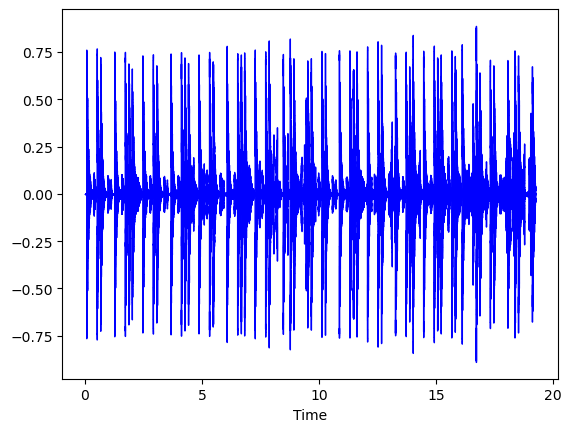

In [22]:
y,sr=librosa.load('archive/Test_submission/Test_submission/100bpm-808-like-drum-loop-74838.wav') #load the file
librosa.display.waveshow(y,sr=sr, axis='time', color='blue')

## As a Mel spectrogram

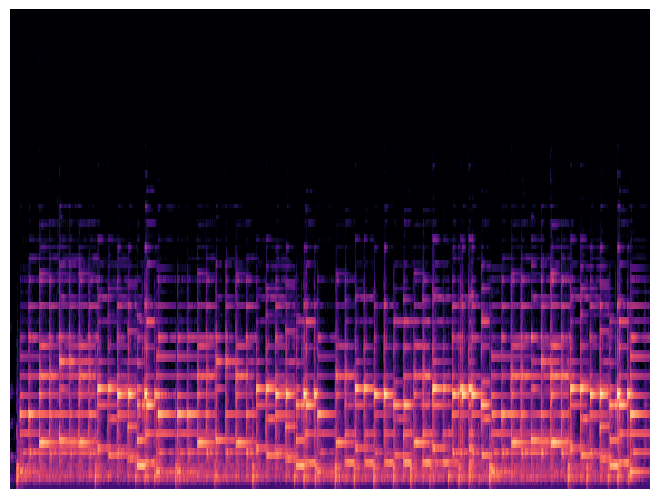

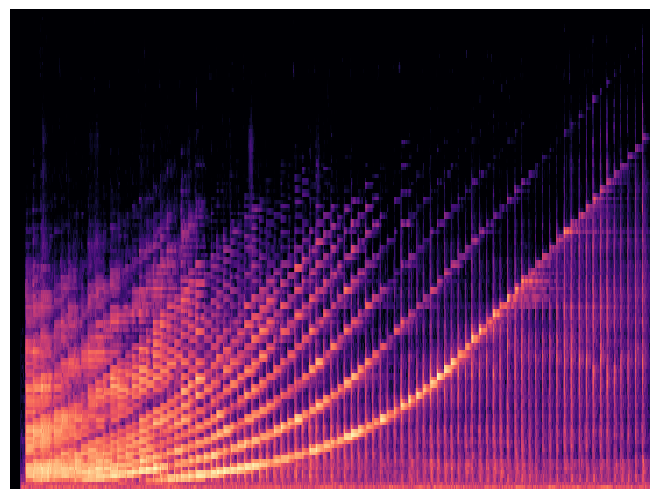

In [150]:
sig, fs = open(dd_train['file'][2])
display_mel((sig,fs))

sig, fs = open(dd_train['file'][1])
display_mel((sig,fs))

## Save Mel spectrograms as images

In [120]:
def split_data(df):
    dd_guitar = df[df['Class'] == 'Sound_Guitar']
    dd_piano = df[df['Class'] == 'Sound_Piano']
    dd_drum = df[df['Class'] == 'Sound_Drum']
    classlist = [dd_guitar, dd_guitar, dd_guitar]
    return classlist

dd_train = dd_train.sample(frac=1).reset_index(drop=True)

dd_val = pd.DataFrame(columns=dd_train.columns)
rows = dd_train[:50]
dd_val = pd.concat([dd_val, rows], ignore_index=True)
dd_train.drop(rows.index, inplace=True)


class_list_test = split_data(dd_test)
class_list_val = split_data(dd_val)
class_list_train = split_data(dd_train)

folder_names = ['Mel_guitar', 'Mel_piano', 'Mel_drum']

#class_list_test = [dd_test_guitar, dd_test_piano, dd_test_drum]
#class_list_val = [dd_val_guitar, dd_val_piano, dd_val_drum]
#class_list_train = [dd_train_guitar, dd_train_piano, dd_train_drum]
# Take each class separately

'''
dd_val_guitar = dd_val[dd_val['Class'] == 'Sound_Guitar']
dd_val_piano = dd_val[dd_val['Class'] == 'Sound_Piano']
dd_val_drum = dd_val[dd_val['Class'] == 'Sound_Drum']

# Reset indexing
dd_val_guitar = dd_val_guitar.reset_index(drop=True)
dd_val_piano = dd_val_piano.reset_index(drop=True)
dd_val_drum = dd_val_drum.reset_index(drop=True)


dd_train_guitar = dd_train[dd_train['Class'] == 'Sound_Guitar']
dd_train_piano = dd_train[dd_train['Class'] == 'Sound_Piano']
dd_train_drum = dd_train[dd_train['Class'] == 'Sound_Drum']

# Reset indexing
dd_train_guitar = dd_train_guitar.reset_index(drop=True)
dd_train_piano = dd_train_piano.reset_index(drop=True)
dd_train_drum = dd_train_drum.reset_index(drop=True)

# Take each class separately
dd_test_guitar = dd_test[dd_test['Class'] == 'Sound_Guitar']
dd_test_piano = dd_test[dd_test['Class'] == 'Sound_Piano']
dd_test_drum = dd_test[dd_test['Class'] == 'Sound_Drum']

# Reset indexing
dd_test_guitar = dd_test_guitar.reset_index(drop=True)
dd_test_piano = dd_test_piano.reset_index(drop=True)
dd_test_drum = dd_test_drum.reset_index(drop=True)

'''


In [126]:
dd_val_drum.head()

,file,Class
0,archive\Train_submission\Train_submission\Real...,Sound_Drum
1,archive\Train_submission\Train_submission\Wave...,Sound_Drum
2,archive\Train_submission\Train_submission\Wave...,Sound_Drum
3,archive\Train_submission\Train_submission\Real...,Sound_Drum
4,archive\Train_submission\Train_submission\oddd...,Sound_Drum


In [127]:
dd_val.shape

(50, 2)

KeyboardInterrupt: 

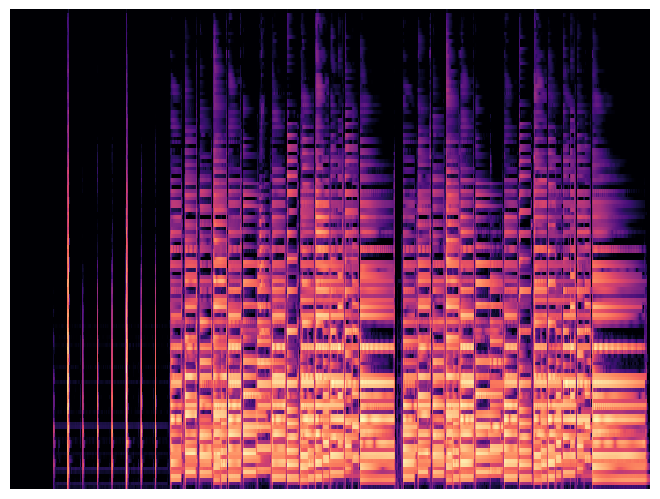

In [128]:
#TODO: Remove the limit to to this for all files.
'''
def save_mel_images(folder_name, folder_names, class_list):

    if not os.path.exists(folder_name):
           os.makedirs(folder_name)

    for folder in folder_names:
        if not os.path.exists(folder_name + '/'+ folder):
           os.makedirs(folder_name + '/' + folder)

    for i, category in enumerate(folder_names):
        # TODO: What axes do we want?
        for j, file in enumerate(class_list[i]['file']):
            #if j == 5:
                #break
            a, b = open(file)
            plt.axis('off') # no axis
            plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    
            S = librosa.feature.melspectrogram(y=a, sr=b)
            librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
            plt.savefig(folder_name + '/' + folder_names[i]+'/mel{}'.format(j)+'.jpg')
            plt.close()

        
save_mel_images('data', folder_names, class_list_train)
save_mel_images('test', folder_names, class_list_test)
save_mel_images('val', folder_names, class_list_val)'''

# Dataset class

In [129]:
# Modified version from HA1
class InstrumentsData(Dataset):
    def __init__(self, root, transform, guitar_label=0, piano_label=1, drum_label=2):
        """Constructor
        
        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """
        
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")
            
        self.root = root
        self.transform = transform
        self._guitar_label = guitar_label
        self._piano_label = piano_label
        self._drum_label = drum_label
        
        # Collect samples, both cat and dog and store pairs of (filepath, label) in a simple list.
        self._samples = self._collect_samples()
        
    def __len__(self):
        return len(self._samples)
        
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path, label = self._samples[index]
        # Load the image into memory
        img = Image.open(path)
        # Perform transforms, if any.
        if self.transform is not None:
            img = self.transform(img)
        return img, label
    
        
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """
        # Iterator over dog filpath
        guitar_paths = self._collect_imgs_sub_dir(self.root / "Mel_guitar")
        # Iterator of pairs (path, dog label)
        # Again, we use the `map` function to create an iterator. It's use is not as common as the so called
        # 'list comprehension' you've previously seen, but a good alternative to have seen.
        guitar_paths_and_labels = map(lambda path: (path, self._guitar_label), guitar_paths)
        # Same for cats
        piano_paths = self._collect_imgs_sub_dir(self.root / "Mel_piano")
        piano_paths_and_labels = map(lambda path: (path, self._piano_label), piano_paths)
        
        drum_paths = self._collect_imgs_sub_dir(self.root / "Mel_drum")
        drum_paths_and_labels = map(lambda path: (path, self._drum_label), drum_paths)
        # Sorting is not strictly necessary, but filesystem globbing (wildcard search) is not deterministic,
        # and consistency is nice when debugging.
        return sorted(list(chain(guitar_paths_and_labels, piano_paths_and_labels, drum_paths_and_labels)), key=lambda x: x[0].stem)

    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.jpg")
    
    def get_sample_by_id(self, id_):
        """Get sample by image id
        
        Convenience method for exploration.
        The indices does not correspond to the image id's in the filenames.
        Here is a (rather inefficient) way of inspecting a specific image.
        
        Args:
            id_ (str): Image id, e.g. `dog.321`
        """
        id_index = [path.stem for (path, _) in self._samples].index(id_)
        return self[id_index]

In [130]:
transform = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

In [131]:
train_dataloader = DataLoader(InstrumentsData("data", transform), batch_size = 32, shuffle=True)
val_dataloader = DataLoader(InstrumentsData("val", transform), batch_size = 32, shuffle=True)

# Make network model
### Used the one from HA1 (Sara's group) as base

In [132]:
class FirstCnn(nn.Module):
    def __init__(self, img_size):
        super(FirstCnn, self).__init__()
        self.first_conv_layer = nn.Conv2d(in_channels=3, kernel_size=3, stride=1, padding=0, out_channels=10)
        self.second_conv_layer = nn.Conv2d(in_channels=10, kernel_size=3, stride=1, padding=0, out_channels=10)
        self.fully_connected_layer = nn.Linear(
            in_features=(img_size-4)*(img_size-4)*10,
            out_features=3
        )
    
    def forward(self, input_batch):
        out = self.first_conv_layer(input_batch)
        out = self.second_conv_layer(out)
        np_flat = out.reshape(input_batch.size(0) ,(out.size(dim=1)*out.size(dim=2)*out.size(dim=3)))
        z = self.fully_connected_layer(np_flat)
        return torch.softmax(z, dim=1).squeeze()

# Functions for training and helpers

In [133]:
# Borrowed from HA1
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.long())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        hard_preds = output_to_label(z)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.long())
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)

In [134]:
def output_to_label(z):   
    c = []
    for preds in z:
        pred = torch.argmax(preds)
        
        c.append(pred.long())
    #device = "cuda"
    return torch.tensor(c)#.to(device)

In [135]:
# TODO: Train for more reasonable amount of samples. Add a validation set.
loss_fn = nn.CrossEntropyLoss()
network = FirstCnn(32)
optim = torch.optim.Adam(network.parameters(),lr=1e-3)

first_model, first_train_losses, first_train_accs, first_val_losses, first_val_accs = training_loop(network, optim, loss_fn, train_dataloader, val_dataloader, 5, 10)

Starting training
	Batch 10/53: 	Train loss: 0.993, 	Train acc.: 0.528, 	Val. loss: 0.898, 	Val. acc.: 0.661
	Batch 20/53: 	Train loss: 0.801, 	Train acc.: 0.759, 	Val. loss: 0.742, 	Val. acc.: 0.839
	Batch 30/53: 	Train loss: 0.729, 	Train acc.: 0.847, 	Val. loss: 0.723, 	Val. acc.: 0.854
	Batch 40/53: 	Train loss: 0.689, 	Train acc.: 0.878, 	Val. loss: 0.680, 	Val. acc.: 0.882
	Batch 50/53: 	Train loss: 0.677, 	Train acc.: 0.897, 	Val. loss: 0.711, 	Val. acc.: 0.854
Epoch 1/5: Train loss: 0.771, Train acc.: 0.789, Val. loss: 0.642, Val. acc.: 0.925
	Batch 10/53: 	Train loss: 0.673, 	Train acc.: 0.887, 	Val. loss: 0.622, 	Val. acc.: 0.938
	Batch 20/53: 	Train loss: 0.664, 	Train acc.: 0.900, 	Val. loss: 0.642, 	Val. acc.: 0.913
	Batch 30/53: 	Train loss: 0.635, 	Train acc.: 0.922, 	Val. loss: 0.669, 	Val. acc.: 0.870
	Batch 40/53: 	Train loss: 0.641, 	Train acc.: 0.909, 	Val. loss: 0.645, 	Val. acc.: 0.941
	Batch 50/53: 	Train loss: 0.612, 	Train acc.: 0.947, 	Val. loss: 0.643, 	Val. 

# Plotting

In [136]:
# YOUR CODE HERE
def plotting(loss_train, loss_val, acc_train, acc_val, batch_value, poly_grade, moving_avg_steps):

    # Create plot
    fig, (ax, ax2) = plt.subplots(1,2)

    # Not a vlaue for val at the same rate as train, so this is to make them fit in the same plot.
    val_x_range = [x*batch_value + batch_value for x in range(len(loss_val))]

    # Scatter plot losses for val and train
    ax.scatter(range(len(loss_train)), loss_train)
    ax.scatter(val_x_range, loss_val, color='lime')
    ax.set_xlabel('Loss')
    ax.set_ylabel('Value')

    # Approximate a polynomial of poly_grade to the training losses to see the trend
    fit_train_losses = np.polyfit(range(len(loss_train)), loss_train, poly_grade)
    train_loss_poly = np.poly1d(fit_train_losses)

    ax.plot(range(len(loss_train)),train_loss_poly(range(len(loss_train))), color='r')
    ax.legend(['Train loss', 'Val loss', 'Train loss polynomial'])

    # Start plotting accuracies
    ax2.scatter(range(len(acc_train)), acc_train)
    ax2.scatter(val_x_range, acc_val, color='lime')
    ax2.set_xlabel('Accuracy')
    ax2.set_ylabel('Percentage')

    # Calcualte moving average for visualizing the trend

    avg = moving_avg(moving_avg_steps, acc_train)
    ax2.plot(range(len(acc_train)), avg, color='r')
    ax2.legend(['Train acc', 'Val acc', 'Train acc moving average'])

    fig.set_figwidth(12)
    fig.show()

def moving_avg(window, values):
    average_y = []
    for i in range(len(values) - window + 1):
     average_y.append(np.mean(values[i:i+window]))

    for i in range(window - 1):
         average_y.insert(0, np.nan)

    return average_y
   
# YOUR CODE HERE

C:\Users\Sara\AppData\Local\Temp\ipykernel_15088\811235515.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


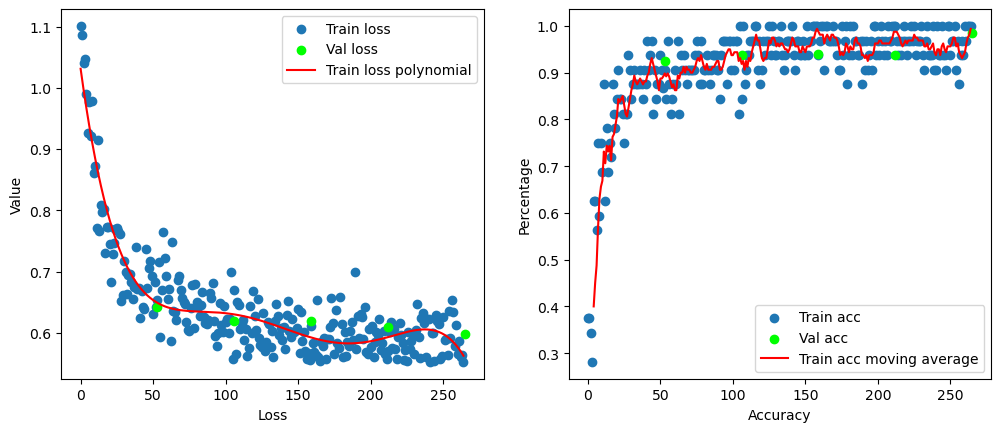

In [137]:
plotting(first_train_losses, first_val_losses, first_train_accs, first_val_accs, 53, 5, 5) 

In [142]:
# YOUR CODE HERE

# Make test data of type DataLoader
test_dataloader = DataLoader(InstrumentsData("test", transform), batch_size = 32, shuffle=True)

accuracy = 0.0
correct_values = 0
y_predictions = []
y_correct = []
# Perform test with no adagrad
with torch.no_grad():
    for batch_x_value, batch_y_value in test_dataloader:
        prediction = network(batch_x_value)
        loss = loss_fn(prediction, batch_y_value)
    
        hard_preds = prediction.argmax(dim=1)
        y_predictions.extend(hard_preds)
        y_correct.extend(batch_y_value)
        
        correct_values += (hard_preds == batch_y_value).sum().item()
        
        accuracy = correct_values/len(InstrumentsData("test", transform))    
    
    print('Test acc: {:.2f} '.format(accuracy))

Test acc: 0.72 


<Axes: >

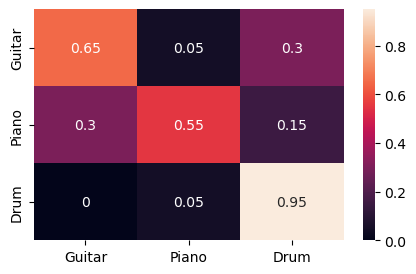

In [145]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
confmat = confusion_matrix(y_correct, y_predictions)
names = ['Guitar', 'Piano', 'Drum']
df_cm = pd.DataFrame(confmat / np.sum(confmat, axis=1)[:, None], index = [i for i in names],
                     columns = [i for i in names])

# Plot matrix and add colours
plt.figure(figsize=(5,3))
sn.heatmap(df_cm, annot=True)

# Everything after this point is unused at the moment

In [ ]:
# Inspired by https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
# Not used at the moment, but could be useful for processing the input later
'''
def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))

def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)
'''

In [ ]:
#def get_transform_audio(file):
#    audio,rate = torchaudio.load(str(file))
#    transform = torchaudio.transforms.Resample(rate,RATE_HZ)
#    audio = transform(audio).squeeze(0).numpy()
#    audio = audio[:MAX_LENGTH] # truncate to first part of audio to save RAM
    # return audio only if it is full length audio
#    if audio.shape[0]==MAX_LENGTH:
#        return audio
#dd['audio'] = dd['file'].progress_apply(get_transform_audio)

## Plays a sound file. Might be useful later

In [ ]:
# Drum example
audio,rate=torchaudio.load('/kaggle/input/musical-instruments-sound-dataset/Train_submission/Train_submission/DRUM_SOUND (48).wav')
transform=torchaudio.transforms.Resample(rate,RATE_HZ)
audio=transform(audio).numpy().reshape(-1)[:MAX_LENGTH]
# make a classification pipeline
pipe(audio)

In [ ]:
# Guitar example
audio,rate=torchaudio.load('/kaggle/input/musical-instruments-sound-dataset/Test_submission/Test_submission/rock_6_100BPM.wav')
transform=torchaudio.transforms.Resample(rate,RATE_HZ)
audio=transform(audio).numpy().reshape(-1)[:MAX_LENGTH]
print(audio.shape)
# make a classification pipeline
pipe(audio)

In [ ]:
from IPython.display import Audio
Audio(audio,rate=RATE_HZ)